In [2]:
import glob
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import polars as pl
import scikit_posthocs as sp
import seaborn as sns
from scipy.stats import levene, probplot

sys.path.append("../src")
from plots import (
    SYNTHWAVE_CATEGORICAL_PALETTE,
    SYNTHWAVE_PALETTE,
    SYNTHWAVE_SINGLE_HUE_PALETTE,
    bolden_ax,
    extend_palette,
    initiate_matplotlib_settings,
    set_boxplot_fill_styles,
    add_titles,
    create_fig_legend,
)

initiate_matplotlib_settings(
    font_path="/home/mball/Library/fonts/Lato",
    style_path="../reports/figure_styles.mplstyle",
)
"""
initiate_matplotlib_settings(
    font_path="/users/mattball/Library/Fonts",
    style_path="../reports/figure_styles.mplstyle",
    font_name="Lato",
)
"""

os.makedirs("../reports/figures/clustering-comparison", exist_ok=True)

In [3]:
SOLVENT_CLASSIFICATION = "coarse"
DATA_DIR = f"../data/parsed_jacs_data/{SOLVENT_CLASSIFICATION}_solvs"

In [4]:
def get_results_from_all_experiments(
    results_folder: str,
    method_col: str,
    filename: str = "top_k_accuracies.csv",
    replace_reagent_type_dict: dict = {
        "coarse_solvent": "Solvent",
        "base": "Base",
        "overall": "Overall",
    },
) -> pl.DataFrame:
    """Gets the top-k accuracies for all repetitions and folds for a given results folder.

    Expects the results folder to have the following structure:
    results_folder
    ├── split_i
    │   ├── fold_j
    │   │   ├── top_k_accuracies.csv

    :param results_folder: The path to the results folder.
    :type results_folder: str
    :param method_col: The name of the method, used to add a method column to the final DataFrame.
    :type method_col: str
    :param filename: The name of the file containing the desired metrics.
    :type filename: str
    :param replace_reagent_type: Whether to replace the reagent type with a more readable name.
    :type replace_reagent_type: bool
    :param solvent_classification: The solvent classification used, when replacing reagent type (e.g. {<solvent_classification>_solvent : Solvent}).
    :type solvent_classification: str
    :return: Results DataFrame.
    :rtype: pl.DataFrame
    """
    combined_results_df = None
    split_results = glob.glob(f"{results_folder}/*")
    split_results.sort()
    for split_result in split_results:
        split = os.path.basename(split_result).split("_")[-1]
        fold_results = glob.glob(f"{split_result}/*")
        fold_results.sort()
        for fold_result in fold_results:
            fold = os.path.basename(fold_result).split("_")[-1]
            try:
                individual_experiment_results_df = pl.read_csv(
                    os.path.join(fold_result, filename)
                )
                individual_experiment_results_df = (
                    individual_experiment_results_df.with_columns(
                        [
                            pl.Series(
                                "split",
                                [split]
                                * len(individual_experiment_results_df),
                            ),
                            pl.Series(
                                "fold",
                                [fold] * len(individual_experiment_results_df),
                            ),
                        ]
                    )
                )

                if combined_results_df is None:
                    combined_results_df = individual_experiment_results_df
                else:
                    combined_results_df = pl.concat(
                        [combined_results_df, individual_experiment_results_df]
                    )
            except Exception as e:
                print(f"Error reading {fold_result}: {e}")
                continue

    if replace_reagent_type_dict is not None:
        combined_results_df = combined_results_df.with_columns(
            [pl.col("reagent_type").replace(replace_reagent_type_dict)]
        )

    combined_results_df = combined_results_df.with_columns(
        [pl.Series("method", [method_col] * len(combined_results_df))]
    )

    return combined_results_df

In [5]:
def get_all_method_results(
    models: list,
    methods: list,
    filename: str,
    results_dir: str = None,
    replace_reagent_type_dict: dict = None,
    solvent_classification: str = SOLVENT_CLASSIFICATION,
    use_coarse_hparams: bool = True,
) -> pl.DataFrame:
    """Gets all the results for a list of models, a results directory, and a filename.

    :param models: A list of the different models to collect results for, where the results for the model are in the {results_dir}/{model}_results directory.
    :type models: list
    :param methods: A corresponding list of the method names for each model (used to add a method column to the final DataFrame).
    :type methods: list
    :param filename: The name of the file containing the desired metrics.
    :type filename: str
    :param results_dir: The results directory, where the individual model results directories can be found, defaults to None
    :type results_dir: str, optional
    :param replace_reagent_type: If true, replaces the reagent names to be more readable, defaults to True
    :type replace_reagent_type: bool, optional
    :param solvent_classification: Solvent classification to find results for, defaults to SOLVENT_CLASSIFICATION
    :type solvent_classification: str, optional
    :param use_coarse_hparams: Whether coarse_hparams were used (changes the model results folder name), defaults to True
    :type use_coarse_hparams: bool, optional
    :return: DataFrame containing all results for the given models.
    :rtype: pl.DataFrame
    """
    all_results_df = None
    if results_dir is None:
        results_dir = f"{DATA_DIR}"
    for model, method in zip(
        models,
        methods,
    ):
        model_results_dir = f"{results_dir}/{model}_results"

        if (
            solvent_classification == "fine"
            and use_coarse_hparams
            and model in ["cgr_rf", "cgr_gbm", "cgr_mtnn", "cgr_dmpnn"]
        ):
            model_results_dir += "_coarse_hparams"

        results_df = get_results_from_all_experiments(
            results_folder=model_results_dir,
            method_col=method,
            filename=filename,
            replace_reagent_type_dict=replace_reagent_type_dict,
        )

        if all_results_df is None:
            all_results_df = results_df
        else:
            all_results_df = pl.concat(
                [all_results_df, results_df.select(all_results_df.columns)]
            )

    return all_results_df

# Reading in the NN-Based Predictions

---

Since the kNN and Pop. Baselines don't 'learn', they can simply be used to predict for the new columns. For the NN-Based models, we need to retrain the models to predict the exact labels, then apply the clustering to see the difference in performance.


In [6]:
def get_top_k_accuracies_from_predictions(
    true_df: pl.DataFrame,
    pred_df: pl.DataFrame,
    solv_exact_to_fine_mapping: dict,
    solv_exact_to_coarse_mapping: dict,
    base_exact_to_coarse_mapping: dict,
    max_k: int = 10,
    exact_cols: list = None,
    target_cols: list = None,
) -> pl.DataFrame:
    """_summary_

    :param true_df: _description_
    :type true_df: pl.DataFrame
    :param pred_df: _description_
    :type pred_df: pl.DataFrame
    :param max_k: _description_, defaults to 10
    :type max_k: int, optional
    :param target_cols: _description_, defaults to None
    :type target_cols: list, optional
    :return: _description_
    :rtype: pl.DataFrame
    """
    if exact_cols is None:
        exact_cols = [
            "exact_base",
            "exact_solvent",
        ]
    if target_cols is None:
        target_cols = [
            "exact_base",
            "exact_solvent",
            "coarse_solvent",
            "fine_solvent",
            "base",
        ]

    for target_col in exact_cols:
        pred_df = pred_df.with_columns(
            pl.col(target_col).map_elements(
                lambda x: ",".join(eval(x)), return_dtype=pl.String
            )
        )

    # Add the solvent and base clusters, using the mapping:
    pred_with_clusters_df = pred_df.with_columns(
        pl.col("exact_solvent")
        .replace(solv_exact_to_fine_mapping)
        .alias("fine_solvent"),
        pl.col("exact_solvent")
        .replace(solv_exact_to_coarse_mapping)
        .alias("coarse_solvent"),
        pl.col("exact_base")
        .replace(base_exact_to_coarse_mapping)
        .alias("base"),
    )

    combined_df = pred_with_clusters_df.join(true_df, on=["rxn_id"])
    combined_df = combined_df.rename(
        {
            f"{target_col}_right": f"true_{target_col}"
            for target_col in target_cols
        }
    )

    top_k_accuracies_df = get_top_k_accuracies_from_combined_df(
        combined_df=combined_df,
        target_cols=target_cols,
    )

    cleaned_top_k_accuracies_df = clean_top_k_accuracies_df(
        top_k_accuracies_df
    )

    return cleaned_top_k_accuracies_df


def clean_top_k_accuracies_df(
    top_k_accuracies_df: pl.DataFrame,
) -> pl.DataFrame:
    top_k_accuracies_df = top_k_accuracies_df.with_columns(
        pl.col("reagent_type").str.split("_").alias("split_reagent_type"),
    )
    top_k_accuracies_df = top_k_accuracies_df.with_columns(
        pl.col("split_reagent_type").list.get(-1).alias("reagent_type"),
        pl.col("split_reagent_type")
        .list.get(0, null_on_oob=True)
        .alias("reagent_classification"),
    ).with_columns(
        pl.col("reagent_type").str.to_titlecase().alias("reagent_type"),
        pl.col("reagent_classification")
        .replace(
            {
                "base": "Coarse",
            }
        )
        .str.to_titlecase(),
    )

    top_k_accuracies_df = top_k_accuracies_df.drop(["split_reagent_type"])
    return top_k_accuracies_df


def get_top_k_accuracies_from_combined_df(
    combined_df: pl.DataFrame, target_cols: list
) -> pl.DataFrame:
    top_k_accuracies = {
        "top_k": [],
        "reagent_type": [],
        "accuracy": [],
    }

    for k in range(1, 11):
        temp_df = combined_df.filter(pl.col("top_k") <= k)
        for target_col in target_cols:
            top_k_accuracy = (
                temp_df.with_columns(
                    pl.col(f"{target_col}")
                    .eq(pl.col(f"true_{target_col}"))
                    .alias(f"match_{target_col}"),
                )
                .group_by("rxn_id")
                .sum()
                .with_columns(
                    pl.when(pl.col(f"match_{target_col}") >= 1)
                    .then(1)
                    .otherwise(0)
                    .alias("found_match")
                )["found_match"]
                .mean()
            )

            top_k_accuracies["top_k"].append(k)
            top_k_accuracies["reagent_type"].append(target_col)
            top_k_accuracies["accuracy"].append(top_k_accuracy)

    top_k_accuracies_df = pl.DataFrame(top_k_accuracies)
    return top_k_accuracies_df


In [7]:
exact_cols = ["exact_base", "exact_solvent"]
target_cols = [
    "exact_base",
    "exact_solvent",
    "coarse_solvent",
    "fine_solvent",
    "base",
]

true_df = pl.read_csv(
    "../data/parsed_jacs_data/splits/split_seed_1/fold_1/data.csv"
).filter(pl.col("dataset") == "test")
pred_with_df = pl.read_csv(
    "../data/parsed_jacs_data/exact_solvs/cgr_mtnn_results/split_seed_1/fold_1/predictions.csv"
)


In [8]:
unique_solvs = true_df["exact_solvent"].unique().to_list()
unique_bases = true_df["exact_base"].unique().to_list()

solv_to_fine = {}
solv_to_coarse = {}
base_to_coarse = {}

for solv in unique_solvs:
    temp_df = true_df.filter(pl.col("exact_solvent") == solv)
    solv_to_fine[solv] = temp_df["fine_solvent"][0]
    solv_to_coarse[solv] = temp_df["coarse_solvent"][0]

for base in unique_bases:
    temp_df = true_df.filter(pl.col("exact_base") == base)
    base_to_coarse[base] = temp_df["base"][0]

In [9]:
models = ["morgan_mtnn", "cgr_mtnn"]
methods = ["Morgan MTNN", "CGR MTNN"]
combined_ml_top_k_accuracies_df = None

for model, method in zip(models, methods):
    for split in range(1, 6):
        for fold in range(1, 6):
            true_df = pl.read_csv(
                f"../data/parsed_jacs_data/splits/split_seed_{split}/fold_{fold}/data.csv"
            ).filter(pl.col("dataset") == "test")
            pred_with_df = pl.read_csv(
                f"../data/parsed_jacs_data/exact_solvs/{model}_results/split_seed_{split}/fold_{fold}/predictions.csv"
            )

            top_k_accuracies_df = get_top_k_accuracies_from_predictions(
                true_df=true_df,
                pred_df=pred_with_df,
                solv_exact_to_fine_mapping=solv_to_fine,
                solv_exact_to_coarse_mapping=solv_to_coarse,
                base_exact_to_coarse_mapping=base_to_coarse,
                exact_cols=exact_cols,
                target_cols=target_cols,
            )

            top_k_accuracies_df = top_k_accuracies_df.with_columns(
                [
                    pl.Series(
                        "split", [str(split)] * len(top_k_accuracies_df)
                    ),
                    pl.Series("fold", [str(fold)] * len(top_k_accuracies_df)),
                    pl.Series("method", [method] * len(top_k_accuracies_df)),
                ]
            )

            if combined_ml_top_k_accuracies_df is None:
                combined_ml_top_k_accuracies_df = top_k_accuracies_df
            else:
                combined_ml_top_k_accuracies_df = pl.concat(
                    [combined_ml_top_k_accuracies_df, top_k_accuracies_df]
                )

top_k_accuracies_df.head()

top_k,reagent_type,accuracy,reagent_classification,split,fold,method
i64,str,f64,str,str,str,str
1,"""Base""",0.605944,"""Exact""","""5""","""5""","""CGR MTNN"""
1,"""Solvent""",0.405561,"""Exact""","""5""","""5""","""CGR MTNN"""
1,"""Solvent""",0.509108,"""Coarse""","""5""","""5""","""CGR MTNN"""
1,"""Solvent""",0.493768,"""Fine""","""5""","""5""","""CGR MTNN"""
1,"""Base""",0.855225,"""Coarse""","""5""","""5""","""CGR MTNN"""


In [10]:
combined_ml_top_k_accuracies_df.filter(pl.col("method") == "CGR MTNN").filter(
    pl.col("reagent_type") == "Solvent"
).filter(pl.col("top_k") <= 1)

top_k,reagent_type,accuracy,reagent_classification,split,fold,method
i64,str,f64,str,str,str,str
1,"""Solvent""",0.385057,"""Exact""","""1""","""1""","""CGR MTNN"""
1,"""Solvent""",0.477011,"""Coarse""","""1""","""1""","""CGR MTNN"""
1,"""Solvent""",0.462644,"""Fine""","""1""","""1""","""CGR MTNN"""
1,"""Solvent""",0.39272,"""Exact""","""1""","""2""","""CGR MTNN"""
1,"""Solvent""",0.487548,"""Coarse""","""1""","""2""","""CGR MTNN"""
…,…,…,…,…,…,…
1,"""Solvent""",0.48659,"""Coarse""","""5""","""4""","""CGR MTNN"""
1,"""Solvent""",0.475096,"""Fine""","""5""","""4""","""CGR MTNN"""
1,"""Solvent""",0.405561,"""Exact""","""5""","""5""","""CGR MTNN"""


In [11]:
models = ["baseline_pop", "baseline_knn"]
methods = ["Pop. Baseline", "KNN"]

combined_clustering_results_df = None

for clustering_type in ["exact", "fine", "coarse"]:
    results_df = get_all_method_results(
        models=models,
        methods=methods,
        filename="independent_top_k_accuracies.csv",
        results_dir=f"../data/parsed_jacs_data/{clustering_type}_solvs",
        replace_reagent_type_dict={
            f"{clustering_type}_solvent": "Solvent",
        },
        solvent_classification=clustering_type,
    )

    results_df = results_df.with_columns(
        [
            pl.Series(
                "reagent_classification",
                [clustering_type.capitalize()] * len(results_df),
            )
        ]
    )

    if combined_clustering_results_df is None:
        combined_clustering_results_df = results_df
    else:
        combined_clustering_results_df = pl.concat(
            [combined_clustering_results_df, results_df]
        )

combined_clustering_results_df = combined_clustering_results_df.with_columns(
    pl.col("reagent_type").replace({"base": "Base"})
).with_columns(pl.col("reagent_type").replace({"exact_base": "Base"}))

In [12]:
combined_ml_top_k_accuracies_df = combined_ml_top_k_accuracies_df.select(
    combined_clustering_results_df.columns
)

all_combined_results_df = pl.concat(
    [combined_clustering_results_df, combined_ml_top_k_accuracies_df]
)

/tmp/ipykernel_1990889/4225986229.py:91: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


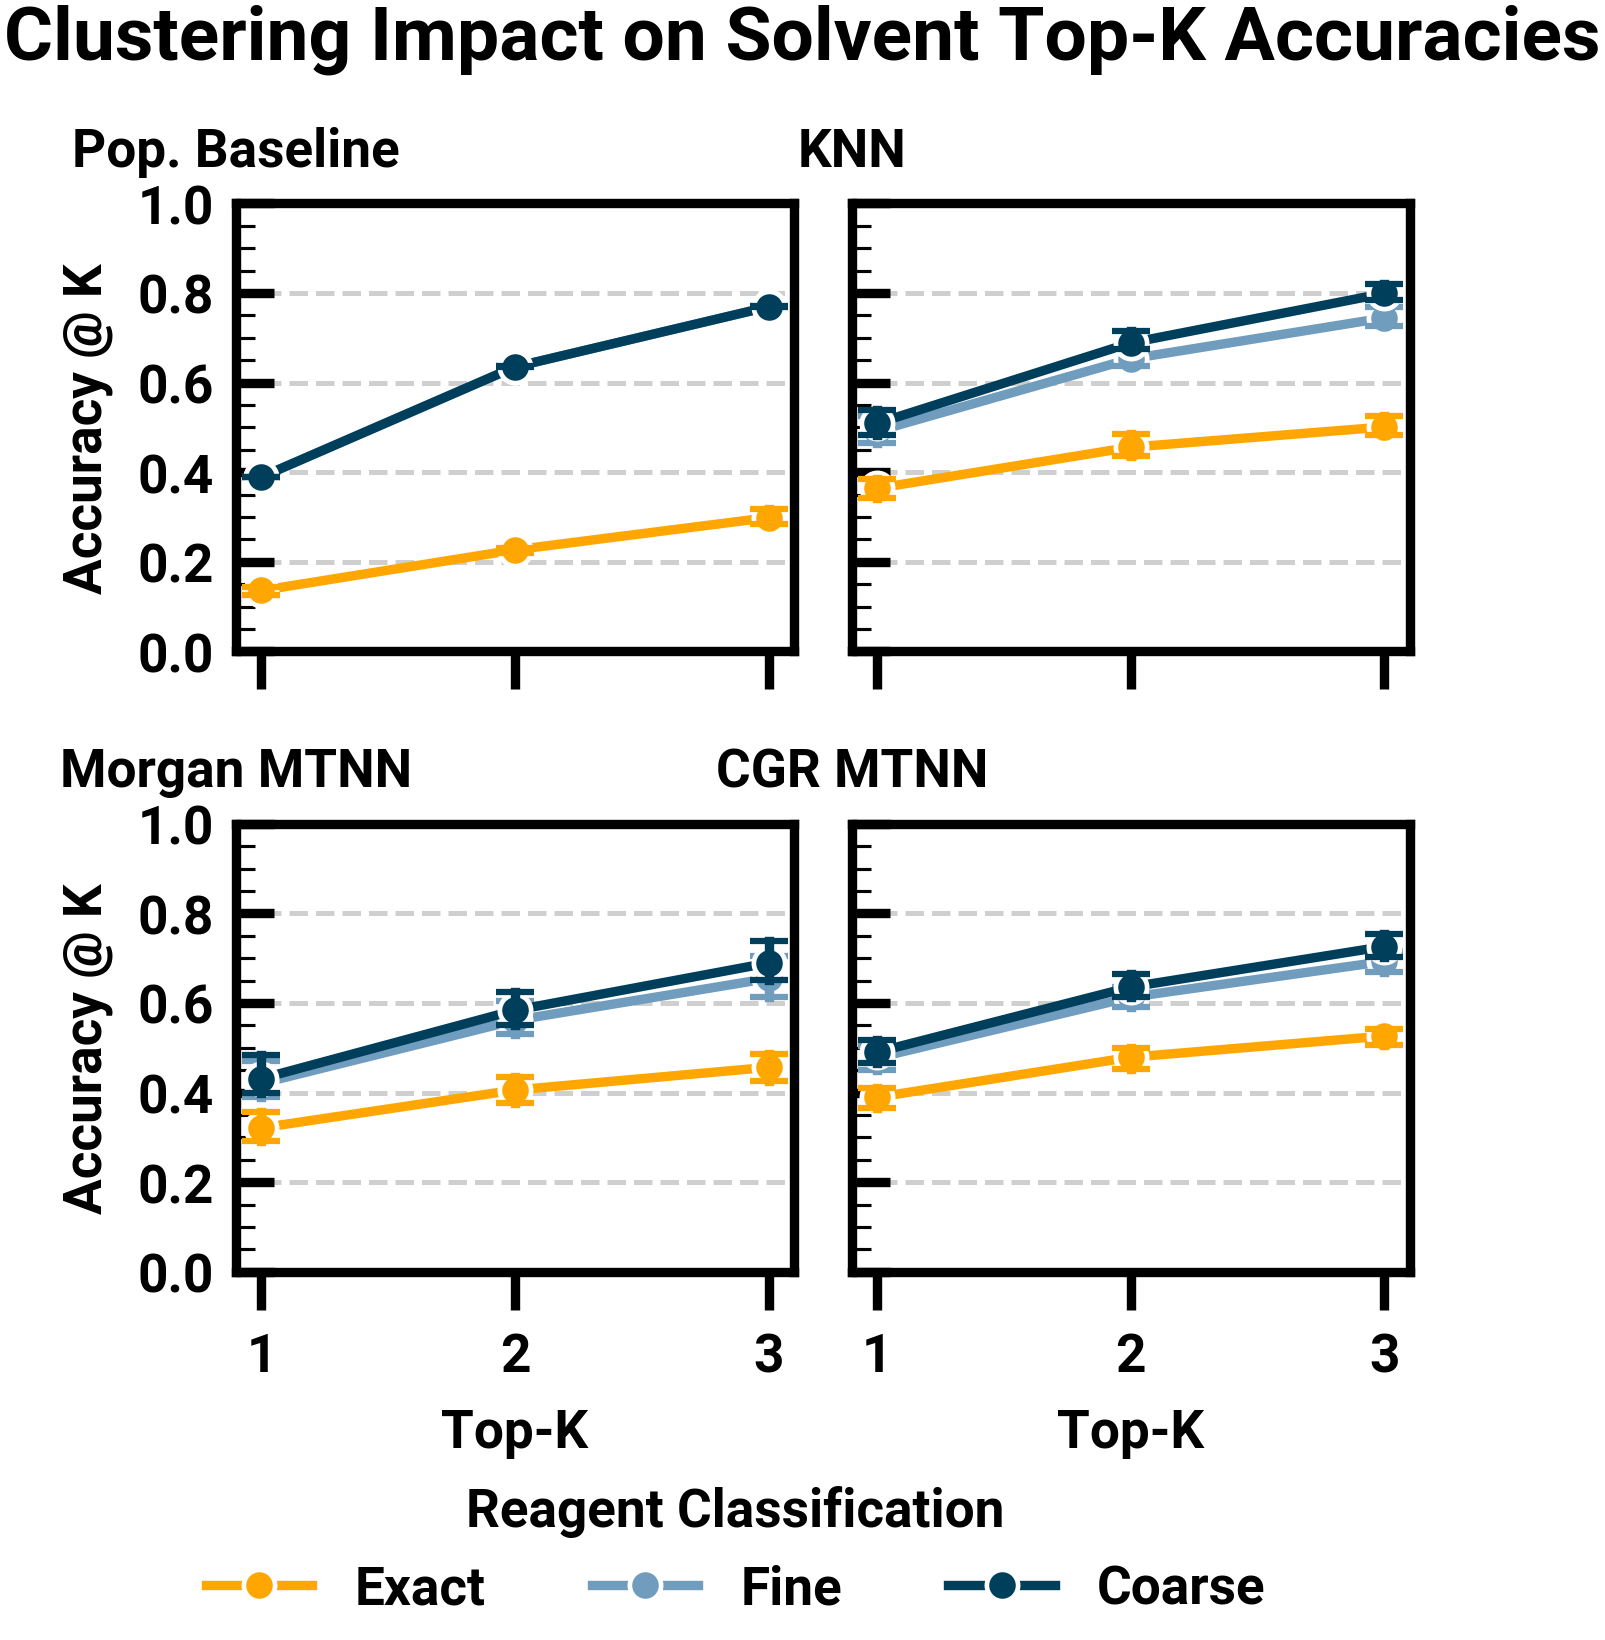

In [ ]:
import numpy as np

custom_palette = [
    SYNTHWAVE_PALETTE[-1],
    SYNTHWAVE_SINGLE_HUE_PALETTE[3],
    SYNTHWAVE_SINGLE_HUE_PALETTE[0],
]

combined_methods = ["Pop. Baseline", "KNN", "Morgan MTNN", "CGR MTNN"]

n_methods = len(combined_methods)

fig, axs = plt.subplots(
    nrows=int(np.ceil(n_methods / 2)),
    ncols=2,
    figsize=(3.25, 3.5 / 2 * n_methods // 2 + 0.5),
    sharex=True,
    sharey=True,
)

for i, method in enumerate(combined_methods):
    ax = axs.flatten()[i]

    temp_df = all_combined_results_df.filter(
        (pl.col("top_k") <= 3)
        & (pl.col("method") == method)
        & (pl.col("reagent_type") == "Solvent")
    )

    temp_df = temp_df.with_columns(
        pl.col("top_k").cast(pl.String),
    )

    sns.lineplot(
        x="top_k",
        y="accuracy",
        hue="reagent_classification",
        hue_order=["Exact", "Fine", "Coarse"],
        data=temp_df.to_pandas(),
        ax=ax,
        # palette=extend_palette(3, SYNTHWAVE_PALETTE),
        palette=custom_palette,
        marker="o",
        markersize=5,
        err_style="bars",
        errorbar=("pi", 95),
        err_kws={"capsize": 3, "elinewidth": 1.5},
    )

    if i == len(methods) - 1:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()
    else:
        ax.legend().remove()

    ax.set_title(method, ha="left", x=0)
    ax.set_xlabel("Top-K")
    ax.set_ylabel("Accuracy @ K")

    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))

    ax.tick_params(axis="x", which="both", direction="out")
    ax.tick_params(axis="x", which="minor", length=0)

    ax.grid(axis="y", linestyle="--", alpha=0.6)

    bolden_ax(
        ax,
        despine=False,
        spine_linewidth=1.5,
        tick_linewidth=1.5,
        label_fontsize=None,
        title_fontsize=None,
        legend_fontsize=None,
    )

fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    ncol=len(all_combined_results_df["reagent_classification"].unique()),
    bbox_to_anchor=(0.5, 0.05),
    frameon=False,
    title="Reagent Classification",
)

fig.suptitle(
    "Clustering Impact on Solvent Top-K Accuracies",
    y=0.96,
    x=0,
    ha="left",
)

fig.tight_layout()

plt.savefig(
    "../reports/figures/clustering-comparison/solvent_top_k_accuracies_coloured_by_clustering_type.svg",
    bbox_inches="tight",
)

In [14]:
baseline_base_results_df = combined_clustering_results_df.filter(
    (pl.col("reagent_type") == "Base")
    & (pl.col("top_k") <= 3)
    & ~(pl.col("reagent_classification") == "Fine")
)

ml_base_results_df = combined_ml_top_k_accuracies_df.filter(
    (pl.col("reagent_type") == "Base")
    & (pl.col("top_k") <= 3)
    & ~(pl.col("reagent_classification") == "Fine")
)

combined_base_results_df = pl.concat(
    [baseline_base_results_df, ml_base_results_df]
).with_columns(
    pl.col("reagent_classification").replace(
        {
            "Coarse": "Clustered",
        }
    )
)

/tmp/ipykernel_1990889/1022057567.py:78: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


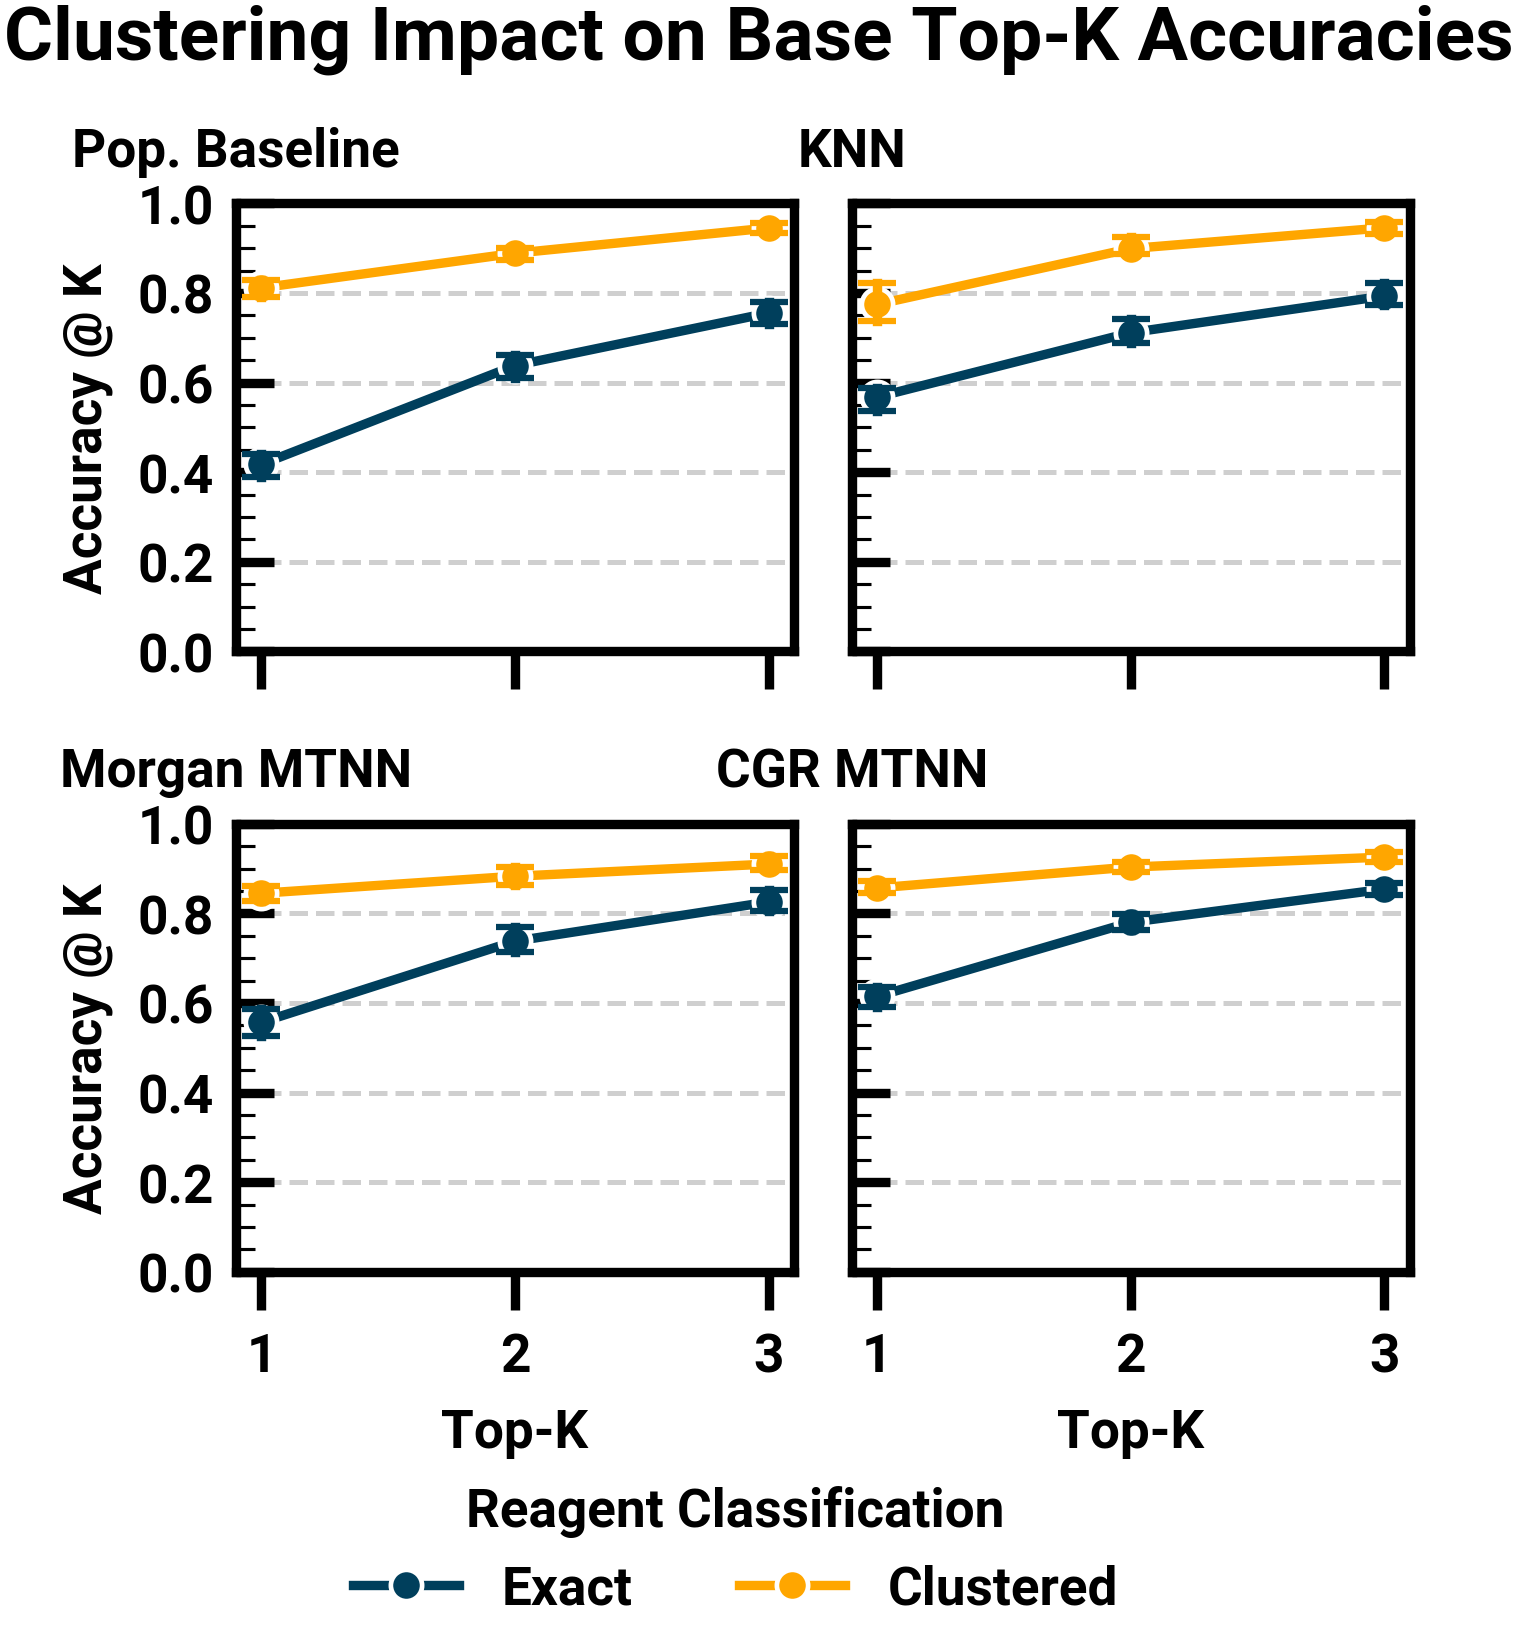

In [30]:
import numpy as np

n_methods = len(combined_methods)

fig, axs = plt.subplots(
    nrows=int(np.ceil(n_methods / 2)),
    ncols=2,
    figsize=(3.25, 3.5 / 2 * n_methods // 2 + 0.5),
    sharex=True,
    sharey=True,
)

for i, method in enumerate(combined_methods):
    ax = axs.flatten()[i]

    temp_df = combined_base_results_df.filter(pl.col("method") == method)

    temp_df = temp_df.with_columns(
        pl.col("top_k").cast(pl.String),
    )

    sns.lineplot(
        x="top_k",
        y="accuracy",
        hue="reagent_classification",
        data=temp_df.to_pandas(),
        ax=ax,
        palette=extend_palette(2, SYNTHWAVE_PALETTE),
        marker="o",
        markersize=5,
        err_style="bars",
        errorbar=("pi", 95),
        err_kws={"capsize": 3, "elinewidth": 1.5},
    )

    if i == len(methods) - 1:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()
    else:
        ax.legend().remove()

    ax.set_title(method, ha="left", x=0)
    ax.set_xlabel("Top-K")
    ax.set_ylabel("Accuracy @ K")

    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))

    ax.tick_params(axis="x", which="both", direction="out")
    ax.tick_params(axis="x", which="minor", length=0)

    ax.grid(axis="y", linestyle="--", alpha=0.6)

    bolden_ax(
        ax,
        despine=False,
        spine_linewidth=1.5,
        tick_linewidth=1.5,
        label_fontsize=None,
        title_fontsize=None,
        legend_fontsize=None,
    )

fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    ncol=len(all_combined_results_df["reagent_classification"].unique()),
    bbox_to_anchor=(0.5, 0.05),
    frameon=False,
    title="Reagent Classification",
)

fig.suptitle(
    "Clustering Impact on Base Top-K Accuracies", y=0.96, x=0, ha="left"
)

fig.tight_layout()

plt.savefig(
    "../reports/figures/clustering-comparison/base_top_k_accuracies_coloured_by_clustering_type.svg",
    bbox_inches="tight",
)

A final interesting comparison, comparing the predictions of the models trained on clustered vs trained on exact and post-processing.


In [16]:
coarse_pre_processed_results_df = get_all_method_results(
    models=["morgan_mtnn", "cgr_mtnn"],
    methods=["Morgan MTNN", "CGR MTNN"],
    filename="independent_top_k_accuracies.csv",
    results_dir="../data/parsed_jacs_data/coarse_solvs",
    replace_reagent_type_dict={
        "coarse_solvent": "Solvent",
        "base": "Base",
    },
    solvent_classification="coarse",
)

coarse_pre_processed_results_df = coarse_pre_processed_results_df.with_columns(
    pl.Series(
        "clustering_applied",
        ["Pre-Processing"] * len(coarse_pre_processed_results_df),
    )
)

fine_pre_processed_results_df = get_all_method_results(
    models=["morgan_mtnn", "cgr_mtnn"],
    methods=["Morgan MTNN", "CGR MTNN"],
    filename="independent_top_k_accuracies.csv",
    results_dir="../data/parsed_jacs_data/fine_solvs",
    replace_reagent_type_dict={
        "fine_solvent": "Solvent",
        "base": "Base",
    },
    solvent_classification="fine",
)

fine_pre_processed_results_df = fine_pre_processed_results_df.with_columns(
    pl.Series(
        "clustering_applied",
        ["Pre-Processing"] * len(fine_pre_processed_results_df),
    )
)

In [17]:
coarse_post_processed_results_df = combined_ml_top_k_accuracies_df.filter(
    (pl.col("reagent_classification") == "Coarse")
)

coarse_post_processed_results_df = (
    coarse_post_processed_results_df.with_columns(
        pl.Series(
            "clustering_applied",
            ["Post-Processing"] * len(coarse_post_processed_results_df),
        )
    )
)

fine_post_processed_results_df = combined_ml_top_k_accuracies_df.filter(
    (pl.col("reagent_classification") == "Fine")
)

fine_post_processed_results_df = fine_post_processed_results_df.with_columns(
    pl.Series(
        "clustering_applied",
        ["Post-Processing"] * len(fine_post_processed_results_df),
    )
)

In [18]:
coarse_comparison_df = (
    pl.concat(
        [
            coarse_pre_processed_results_df,
            coarse_post_processed_results_df.select(
                coarse_pre_processed_results_df.columns
            ),
        ]
    )
    .filter(pl.col("top_k") == 1)
    .filter(pl.col("reagent_type") == "Solvent")
)

fine_comparison_df = (
    pl.concat(
        [
            fine_pre_processed_results_df,
            fine_post_processed_results_df.select(
                fine_pre_processed_results_df.columns
            ),
        ]
    )
    .filter(pl.col("top_k") == 1)
    .filter(pl.col("reagent_type") == "Solvent")
)

/tmp/ipykernel_1990889/3419230330.py:77: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


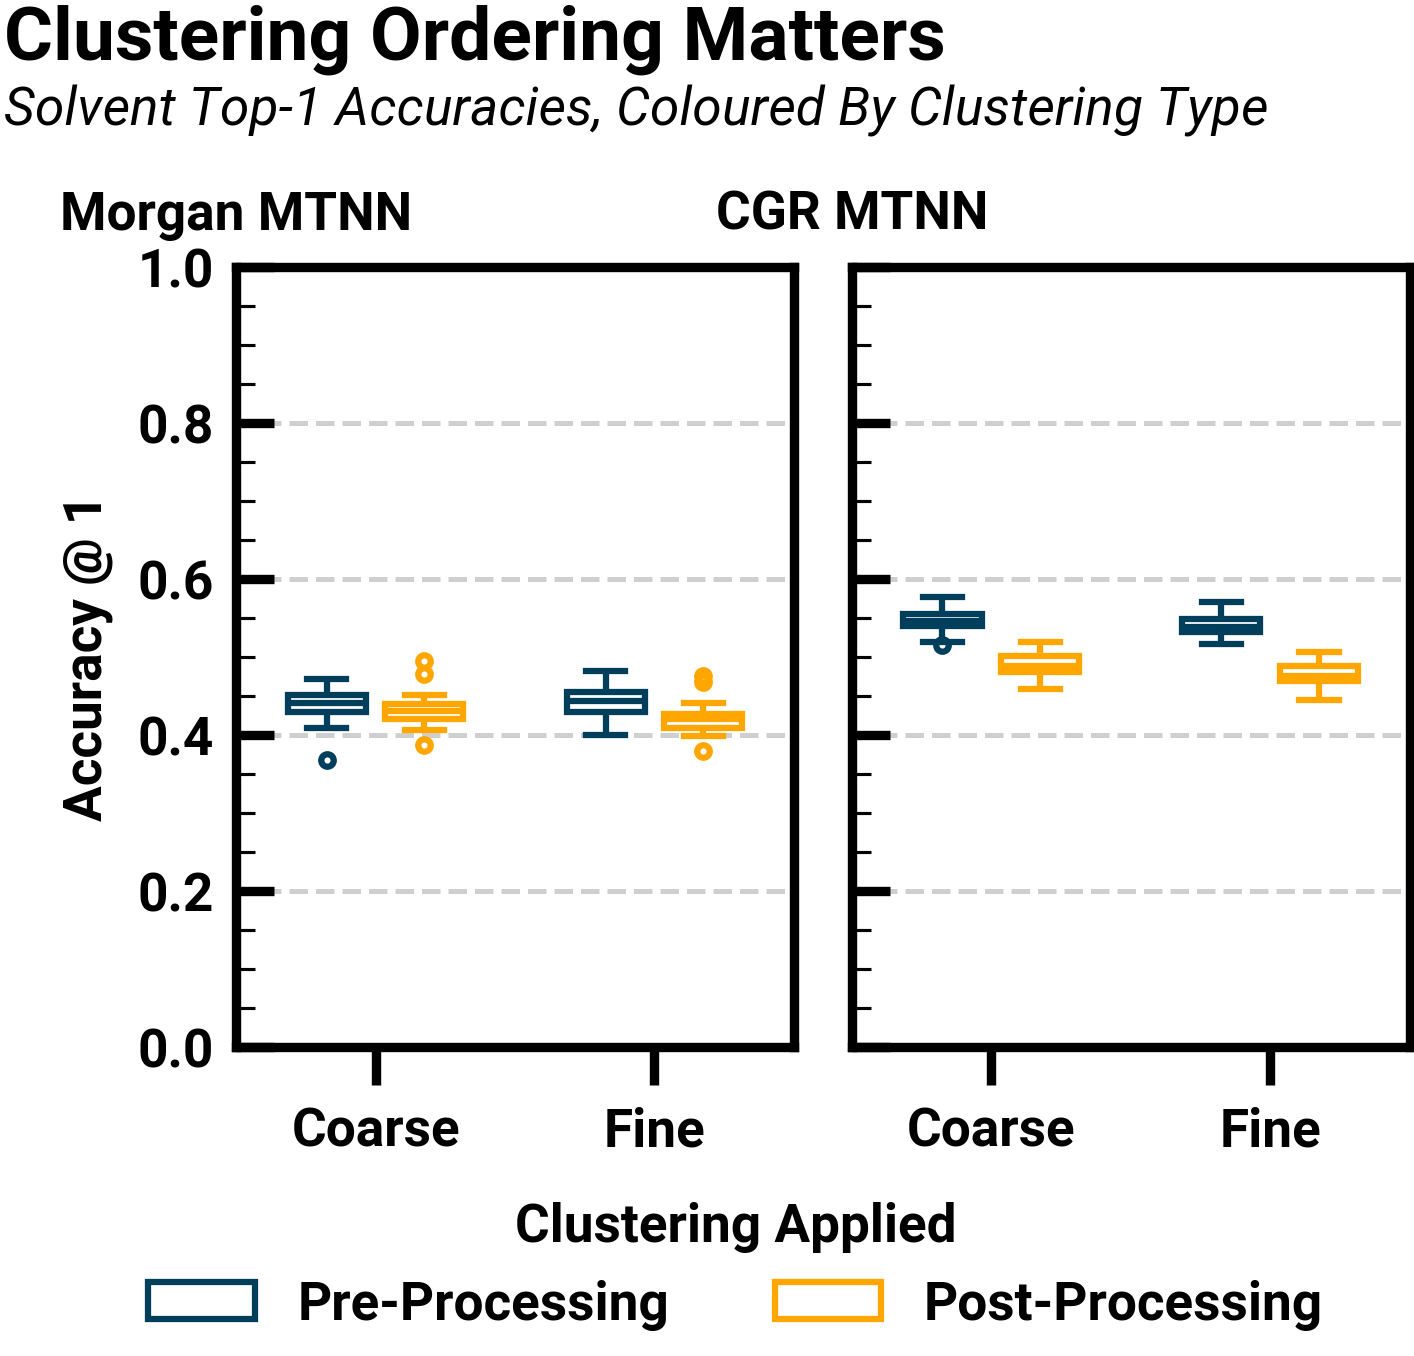

In [ ]:
fig, axs = plt.subplots(figsize=(3.25, 2.69), ncols=2, sharey=True)

vis_df = pl.concat(
    [
        coarse_comparison_df.with_columns(
            pl.Series(
                "reagent_classification",
                ["Coarse"] * len(coarse_comparison_df),
            )
        ),
        fine_comparison_df.with_columns(
            pl.Series(
                "reagent_classification", ["Fine"] * len(fine_comparison_df)
            )
        ),
    ]
)

for i, method in enumerate(["Morgan MTNN", "CGR MTNN"]):
    ax = axs.flatten()[i]

    temp_df = vis_df.filter(pl.col("method") == method)

    sns.boxplot(
        x="reagent_classification",
        y="accuracy",
        hue="clustering_applied",
        data=temp_df.to_pandas(),
        palette=extend_palette(2, SYNTHWAVE_PALETTE),
        saturation=1,
        dodge=True,
        ax=ax,
        width=0.7,
        gap=0.2,
        fliersize=2,
    )

    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.tick_params(axis="x", which="both", direction="out")
    ax.tick_params(axis="x", which="minor", length=0)

    ax.set_xlabel("")
    ax.set_ylabel("Accuracy @ 1")
    ax.set_title(method, ha="left", x=0)

    ax.grid(axis="y", linestyle="--", alpha=0.6)

    set_boxplot_fill_styles(fill=False, ax=ax)

    bolden_ax(
        ax,
        despine=False,
        spine_linewidth=1.5,
        tick_linewidth=1.5,
        label_fontsize=None,
        title_fontsize=None,
        legend_fontsize=None,
    )
    if i == 0:
        ax.legend().remove()

create_fig_legend(
    fig=fig,
    axs=axs,
    title="Clustering Applied",
    n_cols=2,
    fill_legend=False,
    bbox_to_anchor=(0.5, 0.05),
)

add_titles(
    fig=fig,
    title="Clustering Ordering Matters",
    subtitle="Solvent Top-1 Accuracies, Coloured By Clustering Type",
)

fig.tight_layout()

plt.savefig(
    "../reports/figures/clustering-comparison/clustering_ordering_matters.svg",
    bbox_inches="tight",
)